In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as mass_richness
import CL_WL_fit_cluster_mass as fit
import CL_fiducial_mass_richness_relation as fiducial

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
ind_profile = np.load('../data/data_new_version/ind_profile_redmapper.pkl', allow_pickle = True)
ind_profile['cluster_id'] = ind_profile['id']

In [4]:
sum_weights_per_cluster_10 = []
sum_weights_per_cluster_5 = []
for i, cl in enumerate(ind_profile):
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 10)
    sum_weights_per_cluster_10.append(np.sum(ind_profile['W_l_true'][i][mask]))
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 5.5)
    sum_weights_per_cluster_5.append(np.sum(ind_profile['W_l_true'][i][mask]))

In [5]:
ind_profile['weight_per_cluster_5'] = np.array(sum_weights_per_cluster_5)*1e27
ind_profile['weight_per_cluster_10'] = np.array(sum_weights_per_cluster_10)*1e27

In [6]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
Gamma_5 = 0.75
Gamma_10 = 0.8

# WL masses

## WL shear profiles

In [7]:
profile_sky_stack = prf.stacked_profile(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin,
                    add_columns_to_bin = ['weight_per_cluster_10','weight_per_cluster_5', 'richness'])

covariance_sky_stack = prf.bootstrap_covariance(profile = ind_profile,
    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

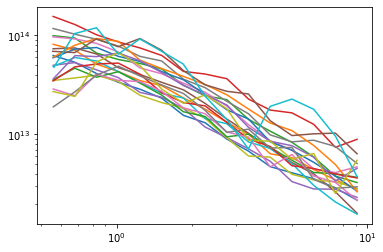

In [8]:
for p in profile_sky_stack:
    plt.loglog(p['radius'], p['gt'])

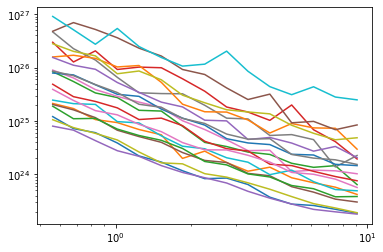

In [9]:
for c in covariance_sky_stack:
    plt.loglog(p['radius'], c['cov_t'].diagonal())

## Fit WL masses

In [10]:
%load_ext autoreload
%autoreload 2
import CL_WL_fit_cluster_mass as fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
hernquist  =       fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False,halo_model = 'hernquist')
nfw =              fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False, halo_model = 'nfw')
einasto =          fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False, halo_model = 'einasto')

fitting...
fitting...
fitting...


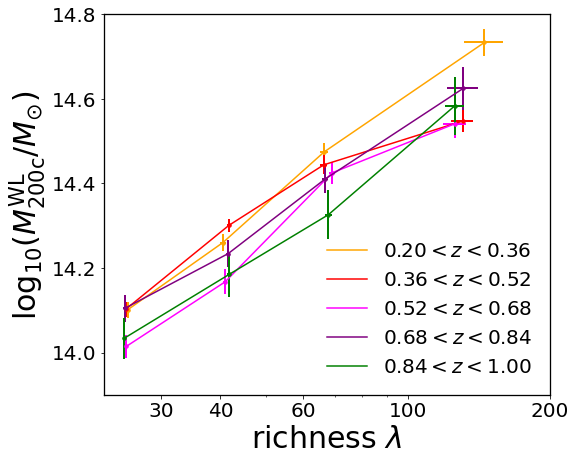

In [74]:
import matplotlib.ticker
fig, ax  = plt.subplots(figsize = (8,7))
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
x = np.linspace(1,3,100)
f = nfw
for k, z_bin in enumerate(Z_bin):
        f = Table(f)
        plt.plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
        mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
        f_cut = f[mask]
        a_t = 1./(1 + f_cut['z_mean'])
        richness = f_cut['obs_mean']
        richness_err = f_cut['obs_rms']
        logm200w = f_cut['logm200_w']
        logm200w_err = f_cut['logm200_w_err']
        ax.errorbar(richness,logm200w,logm200w_err, richness_err,
                    marker = '.', fmt = '-',
                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
                        markerfacecolor = None)

ax.set_ylim(13.9,14.8)
ax.set_xscale('log')
ax.tick_params(axis='both', which = 'major', labelsize= 20)
ax.set_xticks([30,40, 60, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(frameon = False, fontsize = 20, loc = 'lower right')
ax.set_xlabel(r'richness $\lambda$', fontsize = 30)
ax.set_ylabel(r'$\log_{10}(M_{\rm 200c}^{\rm WL}/M_{\odot})$', fontsize = 30)
plt.savefig('redmapper_weak_lensing_masses_nfw_effect_modeling.png', bbox_inches='tight', dpi=300)

# WL Mass-richness relation

In [13]:
fits = [nfw, hernquist, einasto]
label_fits = ['NFW', 'Hernquist', 'Einasto']

In [14]:
lnL = mass_richness.WL_Mass_Richness()

In [15]:
z0 = analysis.z0
richness0 = analysis.richness0
initial_binned = [14.1,-1,.75]
npath = 100
ndim=3
nwalkers = 800
pos_binned = initial_binned + 0.01 * np.random.randn(nwalkers, len(initial_binned))
label = label_fits
sampler_list = {name : 0 for name in label}

for i,fit_true in enumerate(fits):
    fit_true = fit_true[fit_true['z_mean'] < .8]
    lnL = mass_richness.WL_Mass_Richness(logm=fit_true['logm200_w'], logm_err=fit_true['logm200_w_err'], 
                 richness=fit_true['obs_mean'], richness_err=None, 
                 z=fit_true['z_mean'], z_err=None,
                 richness_individual=None, 
                 z_individual=None, 
                 n_cluster_per_bin=None, weights_individual=None)
    lnL.set_pivot_values(z0, richness0)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL.lnLikelihood_binned_classic,)
    sampler.run_mcmc(pos_binned, npath,progress=True)
    sampler_wl = sampler.get_chain(discard = 0, flat = True)
    sampler_list[label[i]] = sampler_wl

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


In [16]:
label_plot = label_fits
sampler_tot = [sampler_list[keys] for keys in sampler_list.keys()]

In [17]:
k = sampler_list['NFW']
a = len(k)
middle = np.mean(k[50000:a-1], axis = 0)
std = np.std(k[50000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 3*std[i], middle[i]+ 3*std[i]) for i in range(3)]

In [18]:
range_corner_plot

[(14.087171019734106, 14.149908856598197),
 (-0.9186361338311806, -0.10969606312265201),
 (0.6760270831910848, 0.8294058924836529)]

80000
80000
80000


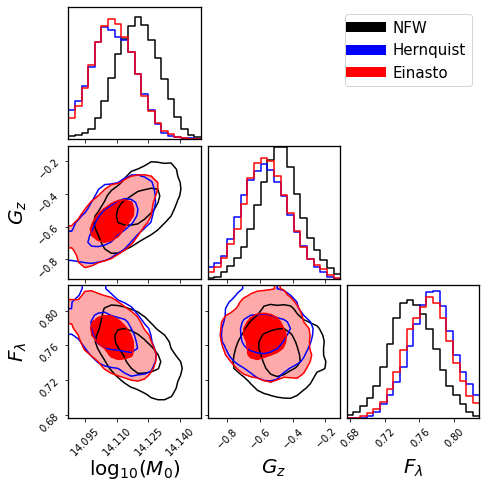

In [23]:
plt.rcParams['axes.linewidth'] = 1.3
labels_param = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
bins = 20
c = ['k', 'b', 'r','k']
show = [True, True, True, True, True]
fill_contours = [False, False, True, False,  False]
fig, axs = plt.subplots(3,3, figsize = (7,7))
for i, name in enumerate(label_plot):
    if not show[i]: continue
    axs[0,2].plot([],[], c[i], linewidth = 10, label = label_fits[i])

for i,sample in enumerate(sampler_tot):
    if not show[i]: continue
    a = len(sample)
    print(a)
    sample_cut = sample[79000:a-1]
    fig = corner.corner(
    sample_cut,
    bins=bins, levels=(sigma1, sigma2),
    range = range_corner_plot,
    fig = fig,
    color = c[i],
    ls = '--',
    smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=fill_contours[i], labels = labels_param,            
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
    plot_density=False,
    max_n_ticks = 5);
    
for i in range(3):
    for j in range(3):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 10)
        #if i == j:
            #axs[i,j].set_ylim(0,7000)
axs[0,2].legend(frameon = True, fontsize = 15, loc = 'upper right')
#plt.savefig('effect_modelling_halo_profile.png', bbox_inches='tight', dpi=300)

In [20]:
np.mean(sampler_list['NFW'][79000:a-1], axis=0)

array([14.11982608, -0.4822987 ,  0.75238319])

In [21]:
np.std(sampler_list['NFW'][70000:a-1], axis=0)

array([0.01039982, 0.13097426, 0.02563034])

In [22]:
a

80000

5 4


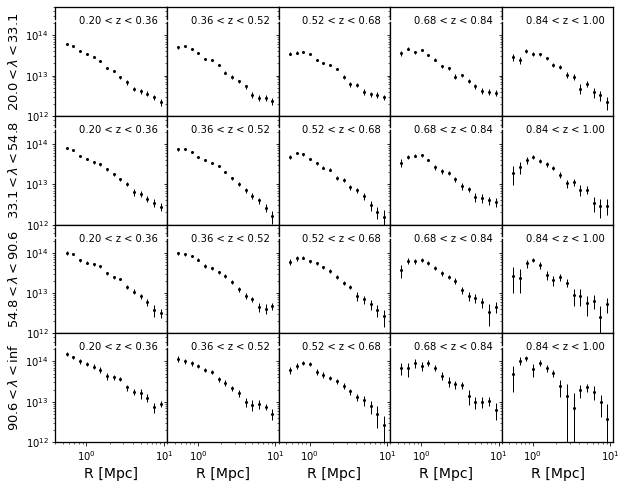

In [72]:
n_z_bin = len(Z_bin) - 0
n_obs_bin = len(Obs_bin) - 0
print(n_z_bin, n_obs_bin)
scale = 3
fig, axs = plt.subplots(n_obs_bin,n_z_bin, figsize = (10,8), sharex = True, sharey = True)
fig.subplots_adjust(wspace=0, hspace=0)
for j, z_bin in enumerate(Z_bin):

    if j >= n_z_bin: continue
        
    for i, m_bin in enumerate(Obs_bin):

    #if i >= n_m_bin: continue
            
        label_z = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}'
        label_M = f'{m_bin[0]:.1f}' + r'$ < \lambda < $' + f'{m_bin[1]:.1f}'
        axs[i, j].set_ylabel(label_M, fontsize = 13)
        axs[i, j].plot([], [], 'w', label = label_z)
        #axs[i, j].plot([], [], 'w', label = label_M)
        c = ['r','b']
        fmt = ['-', '--']
        marker = ['o', 's']
        markersize = [2,2]
        profile_ = nfw
        covariance = [covariance_sky_stack]
        mask_z = (profile_['z_mean'] > z_bin[0])*(profile_['z_mean'] < z_bin[1])
        mask_m = (profile_['obs_mean'] > m_bin[0])*(profile_['obs_mean'] < m_bin[1])
        index = np.arange(len(profile_))
        index_cut = index[mask_m * mask_z]
        f_cut = profile_[index_cut]
        if len(f_cut) == 0: continue
        gt_err = np.array(covariance_sky_stack[index_cut]['gt_err'])

        axs[i, j].errorbar(f_cut['radius'][0,:], np.array(f_cut['gt'])[0,:], gt_err[0], c = 'k'
                           ,marker = 'o',fmt = ' ', elinewidth = 1, capsize = 0, markersize = 2, markerfacecolor = None)
     
        c = f_cut['c_w'][0]
        label_n = f'c = {c:.2f}'
        #axs[i, j].plot([], [], 'w', label = label_n)
        axs[i, j].set_ylim(1e12, 5e14)
        axs[i, j].set_xlim(0.4, 11)
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].legend(frameon = False, loc = 'upper right', fontsize = 10)
        axs[i, j].set_xlabel('R [Mpc]', fontsize = 14)
        #axs[i, j].set_ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 14)

for ax in fig.get_axes():
    ax.label_outer()
plt.savefig('profile_redmapper_fro_effect_of_modelling.png', bbox_inches='tight', dpi=300)